## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

In [1]:
import os
import cv2
import glob
import time
import pickle
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

%matplotlib inline

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

#just a silly wrapper to read images
"""
The training dataset provided for this project ( vehicle and non-vehicle images) are in the .png format. 
Somewhat confusingly, matplotlib image will read these in on a scale of 0 to 1, but cv2.imread() 
will scale them from 0 to 255. Be sure if you are switching between cv2.imread() and matplotlib image 
for reading images that you scale them appropriately! Otherwise your feature vectors can get screwed up.

To add to the confusion, matplotlib image will read .jpg images in on a scale of 0 to 255 so if 
you are testing your pipeline on .jpg images remember to scale them accordingly. 
And if you take an image that is scaled from 0 to 1 and change color spaces using cv2.cvtColor() 
you'll get back an image scaled from 0 to 255. So just be sure to be consistent between 
your training data features and inference features!

Colorspaces: OpenCV uses BGR, matplotlib likes RGB!
"""
def my_readimg(filename, method='xxx'):
    try:
        if method == 'CV2':
            return cv2.imread(filename)
        else:
            return mpimg.imread(filename)
    except:
        print("Oops!", filename)
    
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
    return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, 
                     cspace='BGR2YCrCb', 
                     orient=9, 
                     pix_per_cell=8, 
                     cell_per_block=2,
                     hog_channel = 0,
                     spatial_size=(32, 32),
                     hist_bins=32):
    # Create a list to append feature vectors to
    features = []
    for file in imgs:
        # Read in each one by one
        image = my_readimg(file)
        
        #conver to to defined color space
        feature_image = convert_color(image, cspace)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = []
        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

def store_image(img, img_dir, fname):
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    img_path = img_dir + fname.split('/')[-1]
    cv2.imwrite(img_path, img)
        

def draw_lines(img, vertices):
    pts= np.int32([vertices])
    cv2.polylines(img, pts, True, (255,0,0),5)

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = my_readimg(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

#read all file names from directories
def read_cars_notcars():
    # Divide up into cars and notcars
    carimages=[]
    ncarimages=[]

    carimages = glob.glob('vehicles/*/*.png')
    ncarimages = glob.glob('non-vehicles/*/*.png')

    cars = []
    notcars = []

    for image in carimages:
        cars.append(image)
    for image in ncarimages:
        notcars.append(image)
    return cars, notcars
    

# Define global shared parameters

In [9]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'BGR2YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

ystart = 400
ystop = 656
scale = 1.5
spatial_size = (32,32)
hist_bins = 32

# Divide up into cars and notcars
cars, notcars = read_cars_notcars()
print(data_look(cars, notcars))

{'n_notcars': 8968, 'image_shape': (64, 64, 3), 'n_cars': 8792, 'data_type': dtype('float32')}


# Test HOG features and visualize

[ 0.01871734  0.00628486  0.01052204 ...,  0.00117922  0.          0.        ]
Feature vector length for one hog channel: 1764
[ 0.00063152  0.          0.         ...,  0.00263095  0.00272596
  0.00518066]
Not car feature vector length for one hog channel: 1764


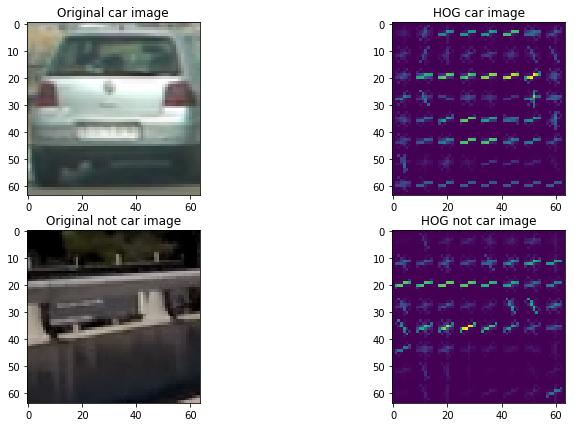

In [36]:
img = my_readimg(cars[21])
nimg = my_readimg(notcars[24])

store_image(img*255, 'output_images/', 'original_car_img_x.png')
feature_image = convert_color(img, colorspace)
store_image(feature_image*255, 'output_images/', 'color_convert_car_img_x.png')
features, hog_img = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block,vis=True)
store_image(hog_img*255, 'output_images/', 'hog_car_img_x.png')
print(features)
print("Feature vector length for one hog channel:", len(features))

store_image(nimg*255, 'output_images/', 'original_notcar_img_x.png')
feature_nimage = convert_color(nimg, colorspace)
store_image(feature_nimage*255, 'output_images/', 'color_convert_notcar_img_x.png')
nfeatures, hog_nimg = get_hog_features(feature_nimage[:,:,0], orient, pix_per_cell, cell_per_block,vis=True)
store_image(hog_nimg*255, 'output_images/', 'hog_notcar_img_x.png')
print(nfeatures)
print("Not car feature vector length for one hog channel:", len(features))

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original car image")
plt.subplot(2, 2, 2)
plt.imshow(hog_img)
plt.title("HOG car image ch 0")

plt.subplot(2, 2, 3)
plt.imshow(nimg)
plt.title("Original not car image")
plt.subplot(2, 2, 4)
plt.imshow(hog_nimg)
plt.title("HOG not car image ch 0")
plt.savefig('output_images/car_notcar_hog_plot_x.png')


In [10]:
def train_svc(cars, notcars):
    # Use a linear SVC
    svc = LinearSVC()
    X_scaler = StandardScaler()
    try:
        svc = joblib.load("svc.pkl")
        X_scaler = joblib.load("scaler.pkl")
        print("using trained model")
    except:
        print("training new model")
        
        t=time.time()
        car_features = extract_features(cars, cspace=colorspace, orient=orient,
                                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                        hog_channel=hog_channel)
        notcar_features = extract_features(notcars, cspace=colorspace, orient=orient,
                                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                        hog_channel=hog_channel)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to extract HOG features...')
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

        print('Using:',orient,'orientations',pix_per_cell,
            'pixels per cell and', cell_per_block,'cells per block')
        print('Feature vector length:', len(X_train[0]))

        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        print('My SVC predicts : ', svc.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'lab: ', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

        joblib.dump(svc,"svc.pkl")
        joblib.dump(X_scaler,"scaler.pkl")
    
    return svc, X_scaler
    

# Train classifier

In [11]:
svc, scaler = train_svc(cars, notcars)

using trained model


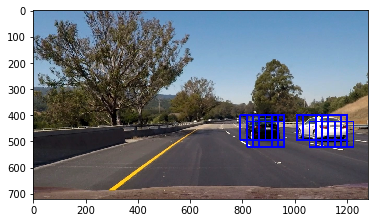

In [40]:
# Define a single function that can extract features using hog sub-sampling and make predictions
# Provided in class by Udacity
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='BGR2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            # Create an array stack of feature vectors
            X = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            #X_scaler = StandardScaler().fit(X)
            test_features = X_scaler.transform(X)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)

    return draw_img

img = my_readimg('test_images/test6.jpg')

out_img = find_cars(img, ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
store_image(out_img,'output_images/','car_detected_test_image_x.png')

## Test pipeline on test images and store output

In [42]:
def process_image(img):
    result = find_cars(img, 
                       ystart, 
                       ystop, 
                       scale, 
                       svc, 
                       scaler, 
                       orient, 
                       pix_per_cell, 
                       cell_per_block, 
                       spatial_size, 
                       hist_bins)
    return result

In [44]:
inputfile = 'project_video.mp4'
out_dir='./'
output = out_dir + 'processed_' + inputfile
clip = VideoFileClip(inputfile)
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


100%|█████████▉| 1260/1261 [07:11<00:00,  3.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 

CPU times: user 8min 44s, sys: 2.24 s, total: 8min 47s
Wall time: 7min 12s
